# New Section

In [5]:
#Textblob is an open-source python library for processing textual data.
!pip install textblob  

!pip install nltk

!pip install swifter

     |████████████████████████████████| 296 kB 47.5 MB/s 
     |████████████████████████████████| 125 kB 50.2 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [8]:
import pandas as pd
import json
import re
import nltk
import string
import swifter

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
  
    
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
    


#filename="News_Category_Dataset_v2.json"

filename="/content/capstoneproject2/part-00000-f48b9de8-0feb-4e1d-9943-df7213008926-c000.csv"

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
from google.colab import drive


csv_dtype_dict={"id": "string",
                "published_time": "string",
                "title":"string",
                "summary":"string",
                "source":"string",
                "category":"string",
                "text":"string"}

In [11]:
# Read CSV
df_news = pd.read_csv(filename, error_bad_lines=False, dtype=csv_dtype_dict)

In [12]:
# Check Columns
df_news.columns

Index(['id', 'published_time', 'title', 'summary', 'source', 'category',
       'text'],
      dtype='object')

In [13]:
from io import StringIO
col = ['category', 'text']
df = df_news[col]
df = df[pd.notnull(df['text'])]
df.columns = ['category', 'text']
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()

,category,text,category_id
0,WORLD,How rich people could help save the planet fro...,0
1,POLITICS,A Mostly Non-Christian Militia Won 2 Of Iraqi ...,1
2,SPORT,The History Of The National Anthem In Sports H...,2
3,QUEER VOICES,Beirut Pride Canceled After Organizer Is Detai...,3
4,POLITICS,#MeToo In The Statehouse: At Least 16 Men Are ...,1


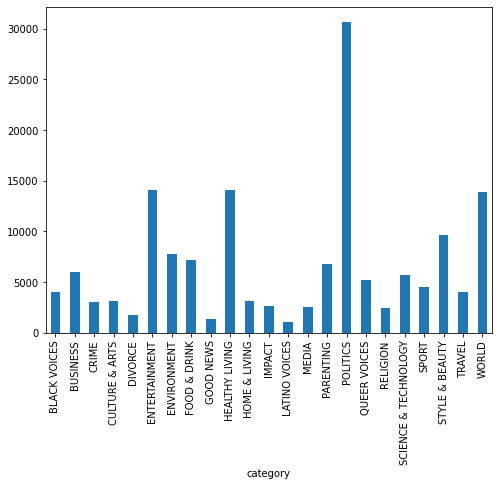

In [14]:
#Imbalanced class

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

In [15]:
#Preprocessing


#1. remove the punctuation from text (ex: .,:)
#2. make lowercase because we assume that punctuation and letter case don’t influence the meaning of words.
#3. use NLTK package remove the called stop_word, i.e frecuent words that doesn’t add information to our classifiers, 
#    example of stop word are: our, you, yourself, he, his, she,them etc. you can review the complete list on this link.
#4. make lemmatization to words, lemmatization is a process of extracting a root word by considering the vocabulary. 
#    For example, “good”, “better”, or “best” is lemmatized (changed) into “good”.


In [16]:
# Text Representation

#limiting the data for first 10k rows due to the memory issue
df1 = df.head(10000)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df1.text).toarray()
labels = df1.category_id
features.shape

(10000, 6395)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


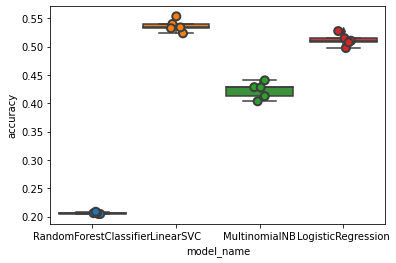

In [17]:
#Model Selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [18]:
#Accuracy comparison for each model
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.5367
LogisticRegression        0.5116
MultinomialNB             0.4226
RandomForestClassifier    0.2060
Name: accuracy, dtype: float64

In [ ]:
# LinearSVC and Logistic Regression perform better than the other two classifiers, 
# with LinearSVC having a slight advantage with a median accuracy of around 66%.
# Lets use Linear SVC model to train and predict the data

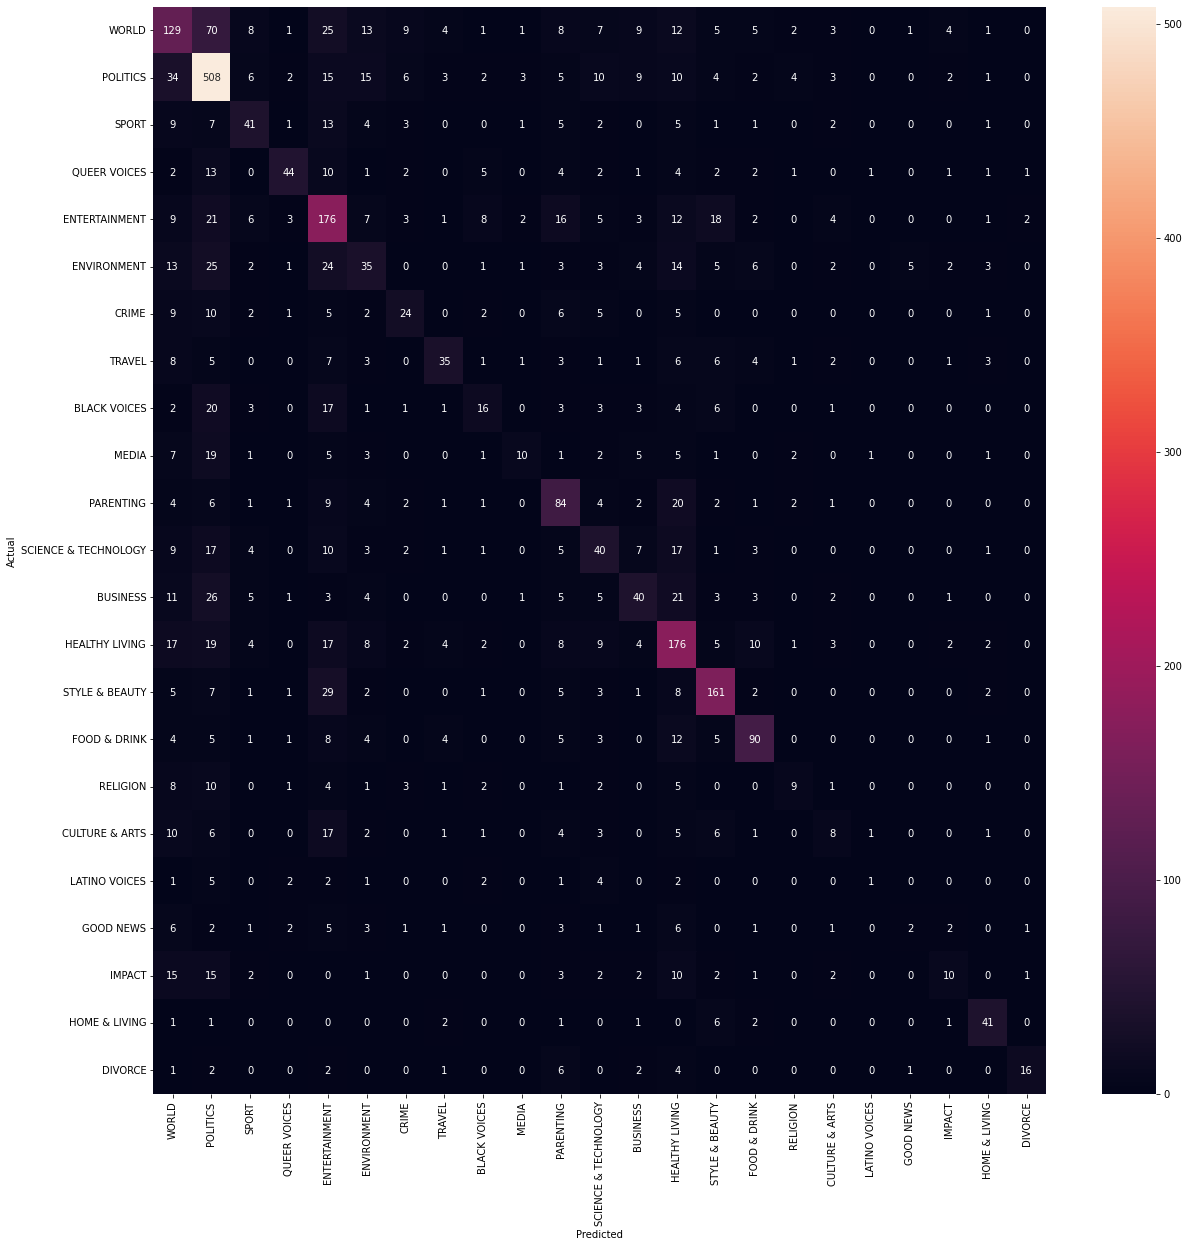

In [19]:
#Model Evaluation

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df1.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Most of the predictions ended up on the diagonal which means the model predictions are good.